## Exploratory Data Analysis of Canadian Bill Data (1994 - 2022)

In [275]:
# Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [276]:
data = pd.read_csv('data/final_data.csv')

In [277]:
display(data.head(3))

,Id,Code,Title,LatestStageName,ParliamentNumber,SessionNumber,BillType,PersonName,ReceivedRoyalAssent,Ongoing,ReadingsPassed,BillOrigin,FirstStageDate,LastStageDate,TimeDebated,SponsorName,SponsorTitle,Constituency,Political Affiliation
0,44-1/S-1,S-1,An Act relating to railways,First reading in the Senate,44,1,Senate Public Bill,,False,True,1,Senate,2021-11-22,2021-11-22,0 days,Yuen Pau Woo,Senator,None,None
1,43-2/S-1,S-1,An Act relating to railways,First reading in the Senate,43,2,Senate Public Bill,,False,False,1,Senate,2020-09-22,2020-09-22,0 days,Marc Gold,Senator,None,None
2,43-1/S-1,S-1,An Act relating to railways,First reading in the Senate,43,1,Senate Public Bill,,False,False,1,Senate,2019-12-04,2019-12-04,0 days,Joseph Day,Senator,None,None


Visualization Ideas:
- Number of bills in each parliament (do parliaments have consistent length?)
- Number and percentage of bills by type
- Percentage of bills that made it to each stage (pie chart)
- Percentage of bills that received royal assent
- Percentage of bills by origin
- Mean, median, and outliers of the time spent debating (amongst bills that received royal assent)
- Number of bills sponsored by political affiliation (take a subset of years as well, compare Harper and Trudeau eras)
- Group the bills by title if possible

Out of Curiosity:
- Which person sponsored the greatest number of bills, also sort by role (Senator, MP, other?)
- Which constituency sponsored the greatest number of bills

### Part 1: Bills by Parliament Number

In [278]:
# Number of bills in each parliament
by_parl = data[[
    'ParliamentNumber', 
    'ReceivedRoyalAssent', 
    'Ongoing', 
    'ReadingsPassed'
]].groupby(['ParliamentNumber'])

by_parl = pd.concat([by_parl.sum(), by_parl.size()], axis = 1)

by_parl.rename(columns = {
    'ReceivedRoyalAssent': 'BillsPassed',
    'ReadingsPassed': 'TotalReadingsPassed',
    0: 'UniqueBills'
}, inplace = True)

display(by_parl)

,BillsPassed,Ongoing,TotalReadingsPassed,UniqueBills
ParliamentNumber,,,,
35,170,0,1600,658
36,124,0,1532,828
37,127,0,1887,1060
38,60,0,743,396
39,85,0,1450,827
40,73,0,1591,1027
41,169,0,1997,1022
42,111,0,1123,442
43,40,0,541,287


In [279]:
# Additional information from wikipedia (https://en.wikipedia.org/wiki/List_of_Canadian_federal_parliaments)

parl_data = pd.read_csv('data/canadian_parliaments.csv')

# Cleaning up the data (loaded direct from Wikipedia, really messy)

parl_data.drop(columns = ['Diagram'], inplace = True)
parl_data.drop(list(range(0, 38)) + [39, 41], axis = 0, inplace = True)

parl_data.columns = [
    'ParliamentNumber', 
    'Duration',
    'GoverningParty',
    'Seats',
    'OfficialOpposition',
    'ThirdParties'
]

# Getting ParliamentNumber

parl_data['ParliamentNumber'] = parl_data['ParliamentNumber'].apply(lambda x: int(x[:2]))

# Creating Start and End Date Columns

parl_data[['StartDate', 'EndDate']] = parl_data['Duration'].str.replace('\n', '').str.split(u'\u2013', 1, expand = True)
parl_data['EndDate'].replace(to_replace = 'present', value = 'Jan 4, 2023', inplace = True)

for col in ['StartDate', 'EndDate']:
    parl_data[col] = pd.to_datetime(parl_data[col].astype(str), format='%b %d, %Y')

parl_data.drop(columns = 'Duration', inplace = True)

# Create Duration Column

parl_data['Duration'] = parl_data['EndDate'] - parl_data['StartDate']

# Split GoverningParty column

parl_data[['Party', 'PrimeMinister']] = parl_data['GoverningParty'].str.split('\n', 1, expand = True)
parl_data['PrimeMinister'] = parl_data['PrimeMinister'].apply(lambda x: x.split('\n')[0].split(' ' , 1)[1].split(u'\u2014')[0])
parl_data.drop(columns = 'GoverningParty', inplace = True)

# Create Minority Column

parl_data['Minority'] = parl_data['Seats'].str.contains('minority')

# Drop unnecessary columns

parl_data.drop(columns = ['Seats', 'OfficialOpposition', 'ThirdParties'], inplace = True)

display(parl_data)


,ParliamentNumber,StartDate,EndDate,Duration,Party,PrimeMinister,Minority
38,35,1993-11-15,1997-04-27,1259 days,Liberal Party,Jean Chrétien,False
40,36,1997-06-23,2000-10-22,1217 days,Liberal Party,Jean Chrétien,False
42,37,2000-12-18,2004-08-23,1344 days,Liberal Party,Jean Chrétien,False
43,38,2004-10-19,2005-11-29,406 days,Liberal Party,Paul Martin,True
44,39,2006-02-13,2008-09-07,937 days,Conservative Party,Stephen Harper,True
45,40,2008-11-04,2011-03-26,872 days,Conservative Party,Stephen Harper,True
46,41,2011-05-23,2015-08-02,1532 days,Conservative Party,Stephen Harper,False
47,42,2015-12-03,2019-09-11,1378 days,Liberal Party,Justin Trudeau,False
48,43,2019-12-05,2021-08-15,619 days,Liberal Party,Justin Trudeau,True
49,44,2021-11-22,2023-01-04,408 days,Liberal Party,Justin Trudeau,True


In [280]:
# Merging by_parliament with parliament_data
by_parl = pd.merge(by_parl, parl_data, on = 'ParliamentNumber', how = 'left')

In [283]:
# Create readings per day and bills per day columns

by_parl['ReadingsPerDay'] = by_parl['TotalReadingsPassed'] / by_parl['Duration'].dt.days
by_parl['BillsPerDay'] = by_parl['BillsPassed'] / by_parl['Duration'].dt.days

In [284]:
display(by_parl)

,ParliamentNumber,BillsPassed,Ongoing,TotalReadingsPassed,UniqueBills,StartDate,EndDate,Duration,Party,PrimeMinister,Minority,ReadingsPerDay,BillsPerDay
0,35,170,0,1600,658,1993-11-15,1997-04-27,1259 days,Liberal Party,Jean Chrétien,False,1.270850,0.135028
1,36,124,0,1532,828,1997-06-23,2000-10-22,1217 days,Liberal Party,Jean Chrétien,False,1.258833,0.101890
2,37,127,0,1887,1060,2000-12-18,2004-08-23,1344 days,Liberal Party,Jean Chrétien,False,1.404018,0.094494
3,38,60,0,743,396,2004-10-19,2005-11-29,406 days,Liberal Party,Paul Martin,True,1.830049,0.147783
4,39,85,0,1450,827,2006-02-13,2008-09-07,937 days,Conservative Party,Stephen Harper,True,1.547492,0.090715
5,40,73,0,1591,1027,2008-11-04,2011-03-26,872 days,Conservative Party,Stephen Harper,True,1.824541,0.083716
6,41,169,0,1997,1022,2011-05-23,2015-08-02,1532 days,Conservative Party,Stephen Harper,False,1.303525,0.110313
7,42,111,0,1123,442,2015-12-03,2019-09-11,1378 days,Liberal Party,Justin Trudeau,False,0.814949,0.080552
8,43,40,0,541,287,2019-12-05,2021-08-15,619 days,Liberal Party,Justin Trudeau,True,0.873990,0.064620
9,44,25,216,457,216,2021-11-22,2023-01-04,408 days,Liberal Party,Justin Trudeau,True,1.120098,0.061275


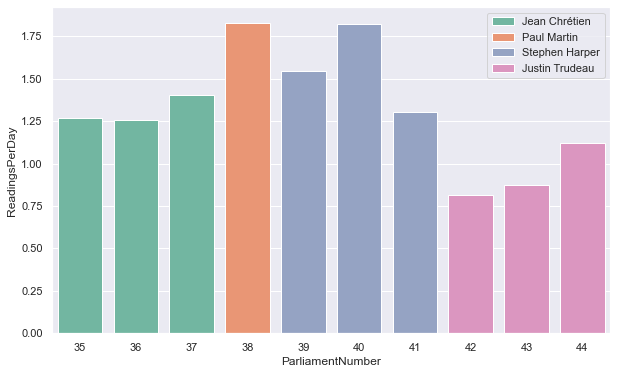

In [318]:
# ReadingsPerDay plot
sns.set(rc = {'figure.figsize':(10,6)})

with sns.color_palette('Set2'):
    sns.barplot(
        x = 'ParliamentNumber', 
        y = 'ReadingsPerDay', 
        hue = 'PrimeMinister', 
        data = by_parl, 
        dodge = False
    )

plt.legend(loc = 'upper right')
plt.show()

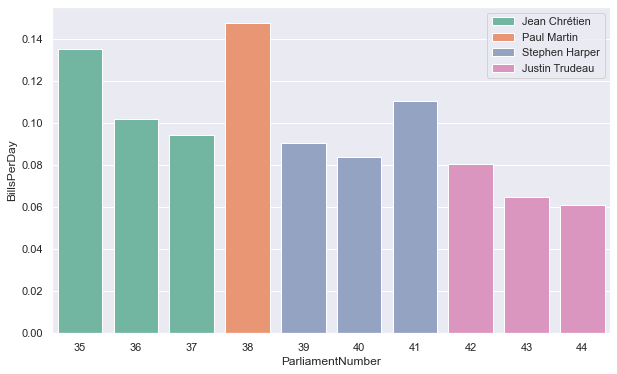

In [317]:
# BillsPerDay plot
sns.set(rc = {'figure.figsize':(10,6)})

with sns.color_palette('Set2'):
    sns.barplot(
        x = 'ParliamentNumber',
        y = 'BillsPerDay', 
        hue = 'PrimeMinister', 
        data = by_parl, 
        dodge = False)

plt.legend(loc = 'upper right')
plt.show()

### Part 2: Bills By Type and Origin

In [306]:
display(data.head(3))

,Id,Code,Title,LatestStageName,ParliamentNumber,SessionNumber,BillType,PersonName,ReceivedRoyalAssent,Ongoing,ReadingsPassed,BillOrigin,FirstStageDate,LastStageDate,TimeDebated,SponsorName,SponsorTitle,Constituency,Political Affiliation
0,44-1/S-1,S-1,An Act relating to railways,First reading in the Senate,44,1,Senate Public Bill,,False,True,1,Senate,2021-11-22,2021-11-22,0 days,Yuen Pau Woo,Senator,None,None
1,43-2/S-1,S-1,An Act relating to railways,First reading in the Senate,43,2,Senate Public Bill,,False,False,1,Senate,2020-09-22,2020-09-22,0 days,Marc Gold,Senator,None,None
2,43-1/S-1,S-1,An Act relating to railways,First reading in the Senate,43,1,Senate Public Bill,,False,False,1,Senate,2019-12-04,2019-12-04,0 days,Joseph Day,Senator,None,None


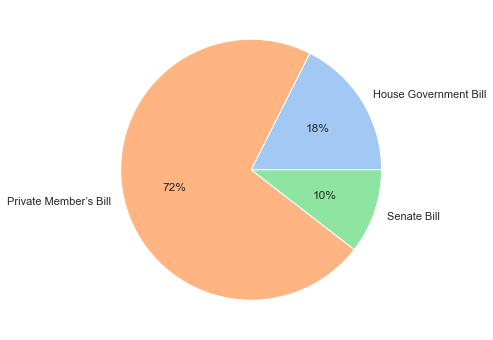

In [382]:
by_billtype = pd.DataFrame(data = data[['BillType']].groupby(['BillType']).size(), columns = ['Count'])
by_billtype['Percent'] = 100 * (by_billtype['Count'] / (by_billtype['Count'].sum()))

senate = by_billtype.loc[by_billtype['Percent'] < 10, :]
senate = pd.DataFrame(
    data = {'Count': [senate['Count'].sum()], 'Percent': [senate['Percent'].sum()]},
    index = ['Senate Bill']
)

by_billtype = pd.concat([by_billtype.loc[by_billtype['Percent'] > 10, :], senate], axis = 0)

with sns.color_palette('pastel'):
    plt.pie(
        x = by_billtype['Percent'], 
        labels = by_billtype.index, 
        autopct='%.0f%%')
    
plt.show()